<a href="https://colab.research.google.com/github/Jupiterian/ATP-Rankings-API/blob/main/barebones_neurosemantics_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment and Dependencies

This section imports core libraries for:
- Data loading and preprocessing
- Neural network modeling with PyTorch
- Contrastive representation learning
- Visualization of learned embeddings

All code is designed to run in **Google Colab** using data accessed from Google Drive.


In [2]:
!pip install nilearn nibabel umap-learn

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap
import seaborn as sns


from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [4]:
import warnings
#Ignore warnings
warnings.filterwarnings('ignore')

## Data Access

The ADNI-derived datasets are stored remotely in Google Drive and loaded directly
into the Colab runtime.

Two data sources are used:
- **Remotely collected speech / language features**
- **MRI-derived structural brain features**

Multiple CSV files are loaded onto the notebook which are then concatenated into a single fused dataset.


##Importing datasets into drive
The following code is designed to import your Google Drive into this environment. In order to access the datasets through google drive - please add a shortcut to the following google drive:
<br/>
[ADNI datasets](https://drive.google.com/drive/folders/1KpyaBEJQz1--kdp341gcPcAwBhgw_qEH?usp=sharing
)
<br/>

If you don't know how to make a shortcut to a folder,
[this article](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) explains it well.

In [5]:
drive.mount("/content/drive")
REMOTE_DIR = "/content/drive/MyDrive/ADNI/Remotely_Collected_Data"
MRI_DIR    = "/content/drive/MyDrive/ADNI/MR_Image_Analysis"

Mounted at /content/drive


# Data Preprocessing
The following code is responsible for preprocessing the data. Here is a step by step explanation of how it works.

## Cell 6
In Cell 6, all CSV files found within the drive folder imported above are joined together onto the same DataFrame using the ```pd.concat``` method. The function is then applied to the REMOTE_DIR and MRI_DIR. Following this, basic manuipulations occur converting all objects in the PTID column to strings.

## Cell 7
In this cell all speech features are organized and sorted into a signular dataframe.

## Cell 8
In this cell all MRI features are organized and sorted into a singular dataframe - in similar fashion to the speech features.

## Cell 9
The speech and MRI features are then merged into one final dataframe.

In [6]:
def load_csv_folder(folder):
    return pd.concat(
        [
            pd.read_csv(os.path.join(folder, f), low_memory=False)
            for f in os.listdir(folder)
            if f.endswith(".csv")
        ],
        ignore_index=True
    )

df_remote = load_csv_folder(REMOTE_DIR)
df_mri    = load_csv_folder(MRI_DIR)

df_remote["PTID"] = df_remote["PTID"].astype(str)
df_mri["PTID"]    = df_mri["PTID"].astype(str)


In [ ]:
speech_features = [c for c in df_remote.columns if c.startswith(("STORY1", "STORY2"))]

speech = (
    df_remote[["PTID"] + speech_features]
    .select_dtypes(include=["number"])
    .groupby(df_remote["PTID"])
    .mean()
    .reset_index()
)


In [ ]:
mri_features = [
    c for c in df_mri.columns
    if c.startswith("ST") and c.endswith(("CV", "SV"))
]

mri = (
    df_mri[["PTID"] + mri_features]
    .select_dtypes(include=["number"])
    .groupby(df_mri["PTID"])
    .mean()
    .reset_index()
)


In [ ]:
#df is fusion dataframe
df = speech.merge(
    mri,
    on="PTID",
    how="inner"
)

print("Final fused dataset:", df.shape)
df.head()

Final fused dataset: (457, 325)


,PTID,STORY1IMM_PLAYBACK_COUNT,STORY1IMM_AUDIO_LENGTH,STORY1IMM_NUM_PRONOUNS,STORY1IMM_NUM_NOUNS,STORY1IMM_NUM_PROPER_NOUNS,STORY1IMM_NUM_VERBS,STORY1IMM_NUM_ADVERBS,STORY1IMM_NUM_ADJECTIVES,STORY1IMM_NUM_WORDS,...,ST9SV,ST147SV,ST148SV,ST149SV,ST150SV,ST151SV,ST152SV,ST153SV,ST154SV,ST155SV
0,002_S_0413,0.0,53.05,20.0,11.0,2.0,14.5,2.0,3.0,80.5,...,1714.983333,222624.943249,225106.405565,447731.348815,218727.833333,217941.000000,436668.833333,48315.166667,588920.904371,9.737131e+05
1,002_S_4213,0.5,47.62,18.5,14.5,2.5,12.5,5.0,3.0,92.5,...,1792.387500,209967.305710,207728.858633,417696.164343,190352.750000,186986.250000,377339.000000,47928.750000,556767.664343,8.863119e+05
2,002_S_4799,0.0,41.08,6.0,7.0,2.0,3.0,0.0,1.0,32.0,...,2006.266667,250450.925246,249114.419315,499565.344561,243200.444444,239326.000000,482526.444444,56701.000000,665996.789005,1.089487e+06
3,002_S_6007,0.0,27.64,5.0,10.5,1.5,5.5,1.0,0.5,43.0,...,2506.725000,220075.740693,223832.554947,443908.295640,213069.875000,209948.125000,423018.000000,52733.500000,602375.295640,9.516920e+05
4,002_S_6053,0.0,54.57,14.0,17.5,4.0,13.5,1.5,6.5,87.5,...,2469.400000,254526.508163,252594.472827,507120.980989,254505.500000,255573.166667,510078.666667,59516.000000,682455.980989,1.132441e+06


In [ ]:
def clean_and_scale(X):
    X[np.isinf(X)] = np.nan
    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])
    return StandardScaler().fit_transform(X)

# Get the actual numerical speech and MRI feature names from the 'speech' and 'mri' dataframes
# (excluding 'PTID' which is not a feature for scaling)
actual_speech_feature_cols = [col for col in speech.columns if col != 'PTID']
actual_mri_feature_cols    = [col for col in mri.columns if col != 'PTID']

# Extract the relevant data from the merged 'df' dataframe, which has the correct 457 PTIDs
X_speech = clean_and_scale(df[actual_speech_feature_cols].values)
X_mri    = clean_and_scale(df[actual_mri_feature_cols].values)

In [ ]:
ptids = df["PTID"].values
train_ids, test_ids = train_test_split(
    np.unique(ptids), test_size=0.2, random_state=42
)

train_mask = np.isin(ptids, train_ids)
test_mask  = np.isin(ptids, test_ids)

X_speech_train, X_speech_test = X_speech[train_mask], X_speech[test_mask]
X_mri_train,    X_mri_test    = X_mri[train_mask],    X_mri[test_mask]

In [ ]:
class PairedDataset(Dataset):
    def __init__(self, Xs, Xm):
        self.Xs = torch.tensor(Xs, dtype=torch.float32)
        self.Xm = torch.tensor(Xm, dtype=torch.float32)

    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, i):
        return self.Xs[i], self.Xm[i]

In [ ]:
train_loader = DataLoader(
    PairedDataset(X_speech_train, X_mri_train),
    batch_size=32,
    shuffle=True
)

In [ ]:
LATENT_DIM = 128
class Encoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, LATENT_DIM)
        )

    def forward(self, x):
        z = self.net(x)
        return F.normalize(z, dim=1)



In [ ]:
def clip_loss(z1, z2, temperature=0.2):
    logits = (z1 @ z2.T) / temperature
    labels = torch.arange(len(z1))
    return (
        F.cross_entropy(logits, labels) +
        F.cross_entropy(logits.T, labels)
    ) / 2


In [ ]:
speech_enc = Encoder(X_speech.shape[1])
mri_enc    = Encoder(X_mri.shape[1])

opt = torch.optim.Adam(
    list(speech_enc.parameters()) + list(mri_enc.parameters()),
    lr=3e-4
)


In [ ]:
speech_enc.train()
mri_enc.train()

train_losses = []

for epoch in range(100):
    total = 0.0

    for xs, xm in train_loader:
        zs = speech_enc(xs)
        zm = mri_enc(xm)

        loss = clip_loss(zs, zm)

        opt.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(
            list(speech_enc.parameters()) + list(mri_enc.parameters()),
            1.0
        )

        opt.step()

        total += loss.item()

    avg_loss = total / len(train_loader)
    train_losses.append(avg_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: {avg_loss:.4f}")


Epoch 0: 3.4078
Epoch 10: 1.1858
Epoch 20: 0.5873
Epoch 30: 0.4018
Epoch 40: 0.3338
Epoch 50: 0.3040
Epoch 60: 0.2830
Epoch 70: 0.2676
Epoch 80: 0.2639
Epoch 90: 0.2518


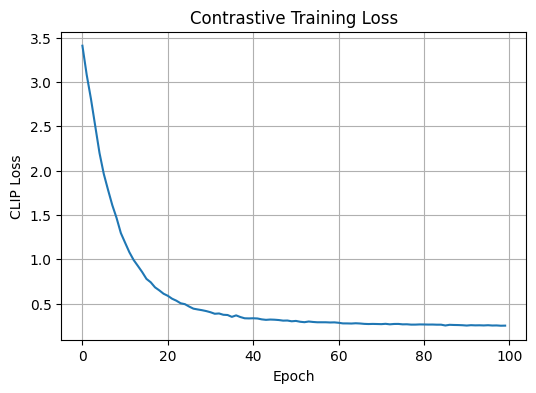

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("CLIP Loss")
plt.title("Contrastive Training Loss")
plt.grid(True)
plt.show()


In [ ]:
speech_enc.eval()
mri_enc.eval()

with torch.no_grad():
    Zs = speech_enc(torch.tensor(X_speech_test, dtype=torch.float32))
    Zm = mri_enc(torch.tensor(X_mri_test, dtype=torch.float32))

    sim = Zs @ Zm.T
    top1 = (sim.argmax(1) == torch.arange(len(sim))).float().mean()
    top5 = (sim.topk(5, dim=1).indices ==
            torch.arange(len(sim)).unsqueeze(1)).any(1).float().mean()

print("Top-1:", top1.item())
print("Top-5:", top5.item())

Top-1: 0.043478261679410934
Top-5: 0.10869564861059189


In [ ]:
speech_enc.eval()
mri_enc.eval()

with torch.no_grad():
    Zs = speech_enc(torch.tensor(X_speech, dtype=torch.float32)).numpy()
    Zm = mri_enc(torch.tensor(X_mri, dtype=torch.float32)).numpy()


In [ ]:
labels = np.array(["Speech"] * len(Zs) + ["MRI"] * len(Zm))
Z = np.vstack([Zs, Zm])

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

Z_2d = reducer.fit_transform(Z)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


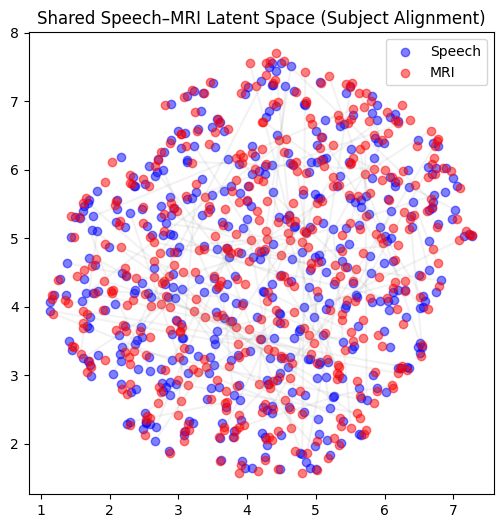

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(Z_2d[:len(Zs),0], Z_2d[:len(Zs),1],
            c="blue", alpha=0.5, label="Speech")
plt.scatter(Z_2d[len(Zs):,0], Z_2d[len(Zs):,1],
            c="red", alpha=0.5, label="MRI")

for i in range(len(Zs)):
    plt.plot(
        [Z_2d[i,0], Z_2d[i+len(Zs),0]],
        [Z_2d[i,1], Z_2d[i+len(Zs),1]],
        c="gray", alpha=0.1
    )

plt.legend()
plt.title("Shared Speech–MRI Latent Space (Subject Alignment)")
plt.show()


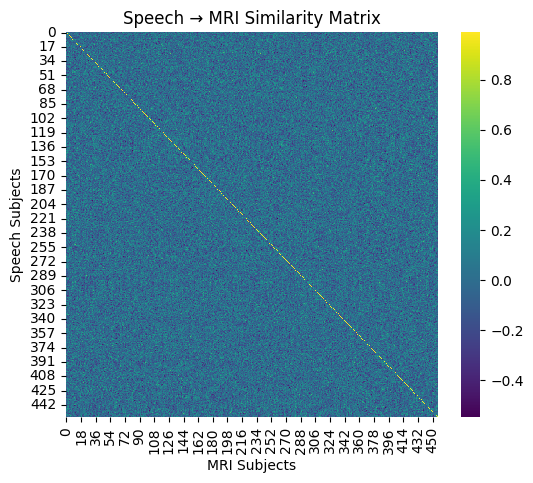

In [ ]:
sim = Zs @ Zm.T

plt.figure(figsize=(6,5))
sns.heatmap(sim, cmap="viridis", cbar=True)
plt.title("Speech → MRI Similarity Matrix")
plt.xlabel("MRI Subjects")
plt.ylabel("Speech Subjects")
plt.show()


In [ ]:
mri_weights = mri_enc.net[0].weight.detach().numpy()
region_importance = np.linalg.norm(mri_weights, axis=0)


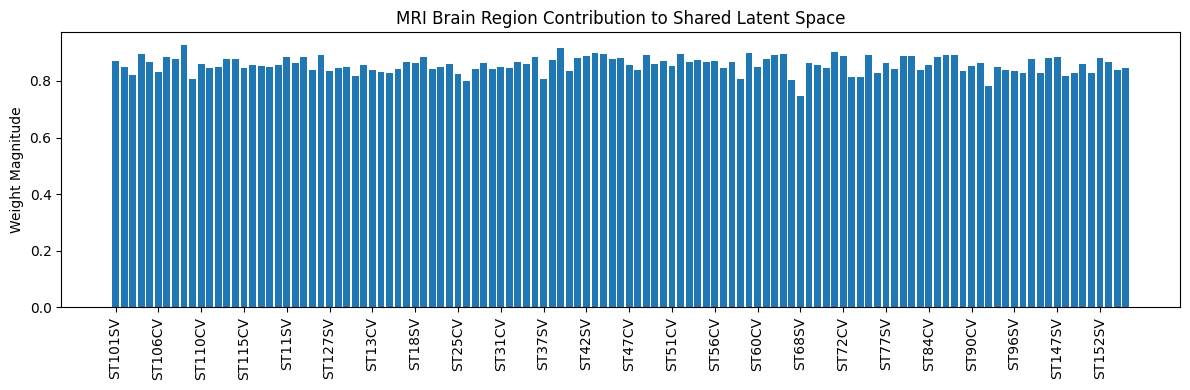

In [ ]:
region_names = actual_mri_feature_cols  # from earlier

plt.figure(figsize=(12,4))
plt.bar(range(len(region_importance)), region_importance)
plt.xticks(
    ticks=range(0, len(region_names), 5),
    labels=[region_names[i] for i in range(0, len(region_names), 5)],
    rotation=90
)
plt.title("MRI Brain Region Contribution to Shared Latent Space")
plt.ylabel("Weight Magnitude")
plt.tight_layout()
plt.show()


# Brain Heatmap

The following is an attempt at creating a brain heatmap. Lets see how it goes.

In [ ]:
!pip install nilearn nibabel


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 73.4 MB/s eta 0:00:00


In [ ]:
from nilearn import datasets

atlas = datasets.fetch_atlas_harvard_oxford(atlas_name='cort-maxprob-thr25-2mm')
atlas_img = atlas.maps
labels = atlas.labels

[fetch_atlas_harvard_oxford] Added README.md to /root/nilearn_data

[fetch_atlas_harvard_oxford] Dataset created in /root/nilearn_data/fsl

[fetch_atlas_harvard_oxford] Downloading data from https://www.nitrc.org/frs/download.php/9902/HarvardOxford.tgz 
...

[fetch_atlas_harvard_oxford]  ...done. (2 seconds, 0 min)

[fetch_atlas_harvard_oxford] Extracting data from 
/root/nilearn_data/fsl/5c734f16e50cc772ef593cab9bb3137b/HarvardOxford.tgz...

[fetch_atlas_harvard_oxford] .. done.

In [ ]:
# Extract region names from MRI feature columns
mri_region_names = []

for col in actual_mri_feature_cols:
    name = col.replace("ST_", "").replace("_CV", "").replace("_SV", "")
    name = name.replace("_", "-")
    mri_region_names.append(name)


In [ ]:
region_importance_dict = {
    region: importance
    for region, importance in zip(mri_region_names, region_importance)
}


In [ ]:
import numpy as np

# Initialize atlas values
atlas_data = np.zeros(len(labels))

for i, label in enumerate(labels):
    if label in region_importance_dict:
        atlas_data[i] = region_importance_dict[label]
    else:
        atlas_data[i] = 0.0


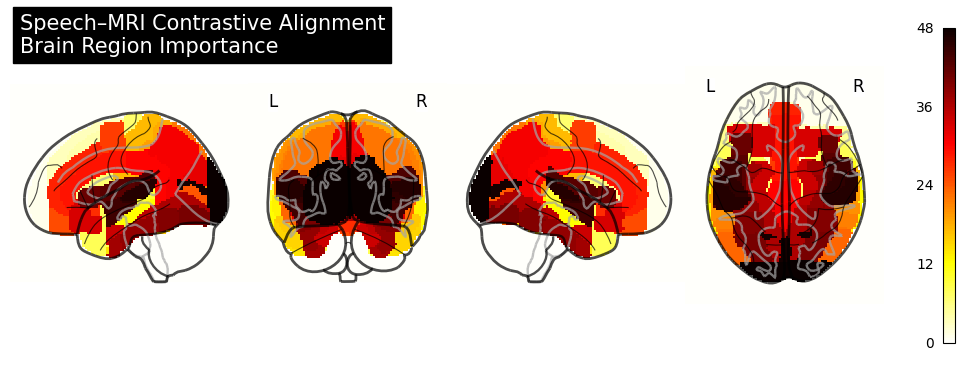

In [ ]:
from nilearn import plotting

plotting.plot_glass_brain(
    atlas_img,
    display_mode="lyrz",
    colorbar=True,
    title="Speech–MRI Contrastive Alignment\nBrain Region Importance"
)


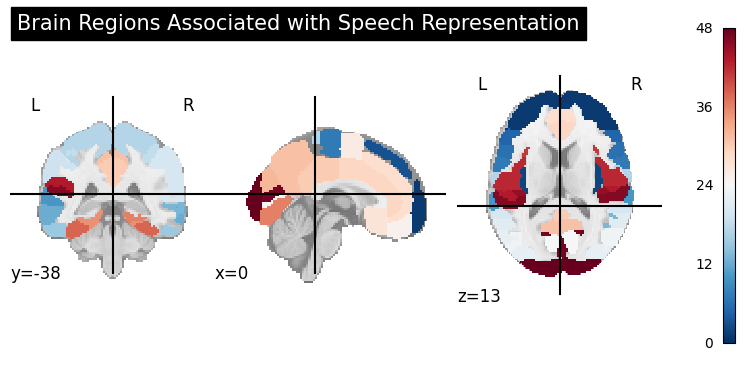

In [ ]:
plotting.plot_stat_map(
    atlas_img,
    title="Brain Regions Associated with Speech Representation",
    colorbar=True,
    threshold=np.percentile(atlas_data, 75)
)